In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier



import matplotlib.pyplot as plt
import os, sys, math
import time, timeit
import csv
from sklearn.utils import shuffle


# from joblib import dump, load

# from IPython.display import Image, display
# from six import StringIO
# from sklearn.tree import export_graphviz
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
max_cardinality = 1.0
root="/Users/liuguanli/Dropbox/应用/Overleaf/ICDE 2023(revision)/figs"

In [2]:
def read_date(file_name):
    df = pd.read_csv(file_name, header=None)
    df = df[df[0] <= max_cardinality]
#     print(df)
    train_x = df[[0,1,2,3,4,5,6,7]]    
    train_y1 = df[[8]]    
    train_y2 = df[[9]]
    return train_x, train_y1, train_y2

In [3]:
build_cost = {}
def build_cost_model(train_x, train_y1, train_y2, name):
    max_depth = 5
    num_of_estimators = 100
    num_of_neurons = 32
    build_models = {
        "FFN" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "RFR" : RandomForestRegressor(max_depth=max_depth, n_estimators=num_of_estimators, random_state=0),
        "RFC" : RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_estimators, random_state=0),
        "DTR" : DecisionTreeRegressor(max_depth=max_depth),
        "DTC" : DecisionTreeClassifier(max_depth=max_depth),
    }
    query_models = {
        "FFN" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "RFR" : RandomForestRegressor(max_depth=max_depth, n_estimators=num_of_estimators, random_state=0),
        "RFC" : RandomForestClassifier(max_depth=max_depth, n_estimators=num_of_estimators, random_state=0),
        "DTR" : DecisionTreeRegressor(max_depth=max_depth),
        "DTC" : DecisionTreeClassifier(max_depth=max_depth),
    }
    if name == "RFR" or name == "DTR" or name == "FFN":
        train_y1 = train_y1 / 6
        train_y2 = train_y2 / 6
#     train_x[0] /= max_cardinality
#     print(train_x, train_y1, train_y2)
    start_time = time.time()
    model = build_models[name].fit(train_x, train_y1), query_models[name].fit(train_x, train_y2)
    time_template = "The training cost of {name} is {value} seconds"
    time_cost = round(time.time() - start_time,4)
    print(time_template.format(name=name, value=time_cost))
    build_cost[name] = {time_cost}
    return model

In [4]:
file_name = 'scorer_formatted.csv'     
train_x, train_y1, train_y2 = read_date(file_name)
models = {
    "FFN" : build_cost_model(train_x, train_y1, train_y2, "FFN"),
    "RFR" : build_cost_model(train_x, train_y1, train_y2, "RFR"),
    "RFC" : build_cost_model(train_x, train_y1, train_y2, "RFC"),
    "DTR" : build_cost_model(train_x, train_y1, train_y2, "DTR"),
    "DTC" : build_cost_model(train_x, train_y1, train_y2, "DTC"),
#     "NNC" : build_cost_model(train_x, train_y1, train_y2, "NNC"),
#     "NN-2" : build_cost_model(train_x, train_y1, train_y2, "NN-2"),
#     "NN-3" : build_cost_model(train_x, train_y1, train_y2, "NN-3")
}


The training cost of FFN is 1.2691 seconds
The training cost of RFR is 0.1294 seconds
The training cost of RFC is 0.1343 seconds
The training cost of DTR is 0.0026 seconds
The training cost of DTC is 0.0022 seconds


In [5]:
class Record:
    def __init__(self, record):
        self.cardinality = float(record[0])
        self.distribution = float(record[1])
        self.method = list(map(int, record[2:8]))      
        self.build_score = float(record[8])        
        self.query_score = float(record[9])
    
    def is_same(self, record):
        if not math.isclose(self.cardinality, record.cardinality):
            return False
        if not math.isclose(self.distribution, record.distribution):
            return False
        if self.method != record.method:
            return False
        return True
            

    def __str__(self):
        return  str(self.cardinality) + "-" + str(self.distribution) + "-" + str(self.method)+ "-" +str(self.build_score) + "-" + str(self.build_score) + "\n"
    
    def __repr__(self):
                return  str(self.cardinality) + "-" + str(self.distribution) + "-" + str(self.method)+ "-" +str(self.build_score) + "-" + str(self.build_score) + "\n"

In [6]:
def read_records(input_data_file):
    records = []
    with open(input_data_file) as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        for i, row in enumerate(reader):
            record = Record(row)
            records.append(record)
    return records

In [7]:
def find_record(target, records):
    for record in records:
        if record.is_same(target):
            return record
    return None

In [8]:
def predict_score(models, name, xs, lamb):
    build_model, query_model = models[name]
#     if name == "NN" and math.isclose(lamb, 0.0):
#         print(query_model.predict(xs))
#     if name == "nn":
#         print( build_model.predict(xs) * lamb, query_model.predict(xs) * (1 - lamb))
    return query_model.predict(xs) * (1 - lamb) + build_model.predict(xs) * lamb #+ query_model.predict(xs) * (1 - lamb)

In [9]:
def test_model(records, models):
    distances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    methods = {'cl':[1,0,0,0,0,0],'mr':[0,1,0,0,0,0],'original':[0,0,1,0,0,0],
                'rl':[0,0,0,1,0,0],'rs':[0,0,0,0,1,0],'sp':[0,0,0,0,0,1]}
    cardinality = [1.0, 0.1, 0.01, 0.001, 0.0001]
    lambdas = [0.1 * i for i in range(11)]
    checked_lambda = 0.1
    checked_name = "RFR"
    model_names = models.keys()
    res = {}
    for name in model_names:
        res[name] = []
    for lamb in lambdas:
        model_accuracy = {}
        
        model_incorrect_source = {}
        model_incorrect_target = {}
        
        total_num = 0
        for name in model_names:
            model_accuracy[name] = 0
            model_incorrect_source[name] = []
            model_incorrect_target[name] = []
        for card in cardinality:
            for dist in distances:
                # here find a method
                best_method = []
                max_score = -100
                missed_candidate = []
                if math.isclose(lamb, checked_lambda):
                    print('---------------real---------------')
                
                for method in methods.keys():
                    record = []
                    record.append(card)
                    record.append(dist)
                    record.extend(methods[method])
                    record.append(0)
                    record.append(0)
                    temp = Record(record)
                    result = find_record(temp, records)
                    if result is None:
                        missed_candidate.append(temp)
                        print(temp)
                        continue
                    current_score = float(result.build_score * lamb) + float(result.query_score * (1 - lamb))
                    if math.isclose(lamb, checked_lambda):
                        print("current_score", method, current_score)
                    if current_score > max_score:
                        max_score = current_score
                        best_method = []
                        best_method.append(method)
                        continue
                        
                    if math.isclose(current_score, max_score):
                        best_method.append(method)
#                 if best_method == '':
#                     continue
#                 if math.isclose(lamb, 0.0) and len(missed_candidate) > 0:
#                     print(missed_candidate[0])
#                 print("lambda", lamb, "cardinality", card, "distribution", dist, "method", best_method)
                total_num += 1
                for name in model_names:
                    max_score = -100
                    choosed_method = ''
                    if name == checked_name and math.isclose(lamb, checked_lambda):
                        print('---------------predict---------------')
                    for method in methods.keys():
                        record = []
                        record.append(card)
                        record.append(dist)
                        record.extend(methods[method])
                        current_score = predict_score(models, name, [record], lamb)
                        if name == checked_name and math.isclose(lamb, checked_lambda):
                            print("current_score", method, current_score)
                        
                        if current_score > max_score:
                            max_score = current_score
                            choosed_method = method
#                     print(name, choosed_method, best_method, choosed_method == best_method)
                    if choosed_method in best_method:
                        model_accuracy[name] = model_accuracy[name] + 1
                    else:
                        model_incorrect_source[name].append((best_method, choosed_method))
#                     else:
                        if name == checked_name and math.isclose(lamb, checked_lambda):
                            print(card, dist)
                            print(name, "best_method:", best_method, "choosed_method:", choosed_method)
        for name in model_names:
            model_accuracy[name] = round(model_accuracy[name] / total_num, 2)
            if math.isclose(lamb, checked_lambda):
                text_template = "---------lambda={la}----incorrect prediction of-----{name}:"
                print(text_template.format(la=round(lamb,1), name=name))
                print(model_incorrect_source[name])
#         print(model_accuracy)
        for name in model_names:
            res[name].append(model_accuracy[name])
#     for name in model_names:
#         print(res[name])
    return res     
res = test_model(read_records(file_name), models)  

---------------real---------------
current_score cl 2.8000000000000003
current_score mr 6.0
current_score original 5.6000000000000005
current_score rl 1.2000000000000002
current_score rs 3.2
current_score sp 5.800000000000001
---------------predict---------------
current_score cl [0.49369453]
current_score mr [0.8648672]
current_score original [0.88638159]
current_score rl [0.41481454]
current_score rs [0.66596231]
current_score sp [0.75643757]
1.0 0.0
RFR best_method: ['mr'] choosed_method: original
---------------real---------------
current_score cl 5.5
current_score mr 6.0
current_score original 5.6000000000000005
current_score rl 1.2000000000000002
current_score rs 2.3
current_score sp 5.800000000000001
---------------predict---------------
current_score cl [0.52917697]
current_score mr [0.89369569]
current_score original [0.8949141]
current_score rl [0.42641313]
current_score rs [0.70821321]
current_score sp [0.77867027]
1.0 0.1
RFR best_method: ['mr'] choosed_method: original
---

---------------real---------------
current_score cl 3.8000000000000003
current_score mr 5.1
current_score original 2.1
current_score rl 5.5
current_score rs 3.1
current_score sp 1.4
---------------predict---------------
current_score cl [0.51074545]
current_score mr [0.71739827]
current_score original [0.61179671]
current_score rl [0.59829775]
current_score rs [0.58750733]
current_score sp [0.54602075]
0.01 0.0
RFR best_method: ['rl'] choosed_method: mr
---------------real---------------
current_score cl 1.1
current_score mr 6.0
current_score original 3.9000000000000004
current_score rl 5.5
current_score rs 4.1
current_score sp 4.0
---------------predict---------------
current_score cl [0.51138961]
current_score mr [0.7382118]
current_score original [0.66137082]
current_score rl [0.63677362]
current_score rs [0.62415474]
current_score sp [0.57556936]
---------------real---------------
current_score cl 3.8000000000000003
current_score mr 6.0
current_score original 4.8
current_score rl 3

current_score mr [0.71634282]
current_score original [0.66405811]
current_score rl [0.4614382]
current_score rs [0.5624092]
current_score sp [0.51026898]
---------------real---------------
current_score cl 5.6000000000000005
current_score mr 6.0
current_score original 3.0
current_score rl 3.7
current_score rs 3.1
current_score sp 1.4
---------------predict---------------
current_score cl [0.7719811]
current_score mr [0.76290044]
current_score original [0.6405828]
current_score rl [0.5664528]
current_score rs [0.63181821]
current_score sp [0.51499078]
0.0001 0.1
RFR best_method: ['mr'] choosed_method: cl
---------------real---------------
current_score cl 3.8000000000000003
current_score mr 6.0
current_score original 3.9000000000000004
current_score rl 1.0
current_score rs 5.800000000000001
current_score sp 4.1
---------------predict---------------
current_score cl [0.59428545]
current_score mr [0.743503]
current_score original [0.67326089]
current_score rl [0.58148359]
current_score rs

0 RFR [0.78, 0.48, 0.78, 0.74, 0.76, 0.68, 0.68, 0.74, 0.96, 1.0, 1.0]
1 RFC [0.5, 0.56, 0.62, 0.62, 0.64, 0.7, 0.68, 0.74, 0.96, 1.0, 1.0]
2 DTR [0.78, 0.56, 0.62, 0.72, 0.76, 0.68, 0.68, 0.74, 0.96, 1.0, 1.0]
3 DTC [0.54, 0.52, 0.56, 0.58, 0.62, 0.68, 0.68, 0.74, 0.96, 1.0, 1.0]
4 FFN [0.82, 0.78, 0.82, 0.82, 0.78, 0.78, 0.68, 0.74, 0.96, 1.0, 1.0]


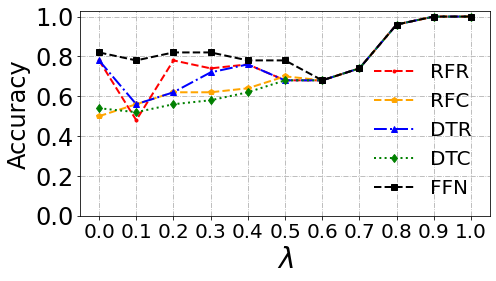

In [10]:
plt.rcParams["figure.figsize"] = (7,4)
lw = 2
labelsize=24
fontsize=24
legend_fontsize=20
lw = 2
x = [i for i in range(11)]
y=[1 for i in range(11)]

model_names = [
    "RFR",     
    "RFC",    
    "DTR",
    "DTC",
    "FFN", 
#     "NNC"
#     "NN-2",
#     "NN-3",
]

# model_names = models.keys()
# print(model_names)

colors = ['red', 'orange', 'blue', 'green', 'black', "purple", "red"]
markers = ['.', 'p', '^', 'd', 's', 'o', 'v']
linestyles = ['--', '--', '-.', ':', '--', "-.", '-.']

for i, name in enumerate(model_names):
    print(i, name, res[name])
    plt.plot(x, res[name],label=name,marker=markers[i],color=colors[i],linestyle=linestyles[i],linewidth=lw)

plt.tick_params(labelsize=fontsize)
# x_ticks = np.arange(0, 16/15, 4/16)
x_ticks = [round(0.1 * i,1) for i in range(11)]
plt.xticks(range(len(x_ticks)), x_ticks, fontsize=20)
# plt.xticks(x_ticks)
# plt.fill_between(x, y1, y2,
#                  facecolor="orange", # The fill color
#                  color='#DDA0DD',       # The outline color
#                  alpha=0.2)          # Transparency of the fill
plt.xlabel("$\lambda$",fontsize=28)
plt.ylabel("Accuracy",fontsize=fontsize)
# plt.yscale('log')
# plt.ylim([0.0, 1.1])

plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.legend(fontsize=legend_fontsize, ncol=1,frameon=False)
plt.grid(True, linestyle='-.')

plt.tight_layout()
plt.savefig(root + "/varying_models_accuracy.eps", format='eps', bbox_inches='tight')
plt.savefig(root + "/varying_models_accuracy.pdf", format='pdf', bbox_inches='tight')

In [11]:
print(build_cost)

{'FFN': {1.2691}, 'RFR': {0.1294}, 'RFC': {0.1343}, 'DTR': {0.0026}, 'DTC': {0.0022}}
